Задание 1. В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

In [1]:
round(10*(0.7**3)*(0.3)**2 + 5*(0.7)**4*0.3 + 1*(0.7)**5,3)*100

83.7

Ответ(1): 83.7

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

In [3]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table

In [4]:
## Считываем данные
data = pd.read_csv('../data/credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [5]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

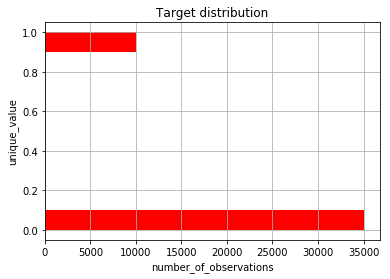

In [6]:
## Посмотрим на распределение классов в зависимой переменной

ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts(normalize=True)

In [7]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [8]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table =delete_nan(data)

In [254]:
## Разделяем таргет и признаки 
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Бутстрэп

Задание 2. Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте np.random.seed(0), как это сделано в статье.

In [10]:
# не просрочили
data[data['SeriousDlqin2yrs'] == 0]['age'].values

array([64, 58, 41, ..., 74, 49, 47], dtype=int64)

In [11]:
# просрочили
data[data['SeriousDlqin2yrs'] == 1]['age'].values

array([49, 31, 37, ..., 31, 38, 45], dtype=int64)

In [12]:
X.shape

(45063, 7)

In [13]:
len(X)

45063

In [18]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return np.round(boundaries,2)

# сохранение в отдельный numpy массив данных по плохим парням
bad_guys = data[data['SeriousDlqin2yrs'] == 1]['age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее

bad_guys_mean_scores = np.mean(get_bootstrap_samples(bad_guys, 1000),axis=1)

#  выводим интервальную оценку среднего
print("Интервальная оценка среднего возраста: ",  stat_intervals(bad_guys_mean_scores, 0.1))

Интервальная оценка среднего возраста:  [45.71 46.13]


Ответ(2): 45.71 – 46.13

# Подбор параметров для модели логистической регрессии


Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе значение метрики ROC-AUC к 1, тем качественнее происходит классификация модели.

In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Задание 3. Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [129]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys();

In [271]:
#C метрикой roc_auc gcv выбрал С=0.001, для roc_auc это ЛУЧШИЙ параметр

gcv = GridSearchCV(lr, parameters, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc');
gcv.fit(X, y);
y_pred = gcv.predict_proba(X)[:,1]
#print('roc_auc_score: ',roc_auc_score(y, y_pred))
print('best_params для roc_auc: ',gcv.best_params_)
print('best_score для roc_auc: ',gcv.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


best_params для roc_auc:  {'C': 0.001}
best_score для roc_auc:  0.7954977787123253


In [269]:
#y_pred = gcv.predict_proba(X)[:,1]
#roc_auc_score(y, y_pred)

In [322]:
gcv.cv_results_

{'mean_fit_time': array([0.41508908, 0.49447775, 0.5950067 , 0.56827812, 0.58403606,
        0.4926805 ]),
 'std_fit_time': array([0.03369363, 0.06077218, 0.05135461, 0.03946933, 0.06646384,
        0.05366064]),
 'mean_score_time': array([0.00757914, 0.0069818 , 0.00817928, 0.00718255, 0.0109714 ,
        0.00638423]),
 'std_score_time': array([0.00119644, 0.00062939, 0.00390882, 0.00097807, 0.00802718,
        0.00048883]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10}],
 'split0_test_score': array([0.78867902, 0.79501895, 0.79187854, 0.78944043, 0.78904763,
        0.78904593]),
 'split1_test_score': array([0.79339284, 0.79740443, 0.7894569 , 0.78715209, 0.78813721,
        0.78812398]),
 'split2_test_score': array([0.79316483, 0.79784779, 0.79226605, 0.790

In [268]:
#C метрикой accuracy gcv выбрал С=0.0001, для roc_auc это НЕ лучший параметр

#gcv = GridSearchCV(lr, parameters, n_jobs=-1, cv=skf, verbose=1);
#gcv.fit(X, y);
#y_pred = gcv.predict_proba(X)[:,1]
#print('roc_auc_score: ',roc_auc_score(y, y_pred))
#print('best_params для accuracy: ',gcv.best_params_)
#print('best_score для accuracy: ',gcv.best_score_)

In [267]:
#y_pred = gcv.predict(X)
#accuracy_score(y, y_pred)

Ответ(3): 0.001

Задание 4. Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [276]:
gcv.cv_results_['std_test_score']

array([0.00531173, 0.00638145, 0.00815289, 0.00821492, 0.00832365,
       0.00791903])

In [280]:
str(100*(gcv.cv_results_['std_test_score'].mean()/gcv.best_score_))+' %'

'0.9282167539091472 %'

In [281]:
gcv.best_score_

0.7954977787123253

Ответ(4): Нет

# Определение влияния признаков

Задание 5. Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [163]:
X.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,64,0,0.249908,0,0,8158.0,0.0
1,58,0,3870.000000,0,0,5166.0,0.0
2,41,0,0.456127,0,0,6666.0,0.0
3,43,0,0.000190,0,0,10500.0,2.0
4,49,0,0.271820,0,0,400.0,0.0


In [311]:
from sklearn.preprocessing import StandardScaler
tmp_scaled1 = StandardScaler().fit_transform(X)

lr = LogisticRegression(C=0.001,random_state=5, class_weight= 'balanced')
lr.fit(tmp_scaled1, y)
lr.coef_

array([[-0.41630368,  0.72400432, -0.02408186,  0.51767292,  0.19473217,
        -0.16286353,  0.10132603]])

In [335]:
# вес признаков с нормализацией

lr = LogisticRegression(C=0.001,random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.724004
3,NumberOfTimes90DaysLate,0.517673
4,NumberOfTime60-89DaysPastDueNotWorse,0.194732
6,NumberOfDependents,0.101326
2,DebtRatio,-0.024082
5,MonthlyIncome,-0.162864
0,age,-0.416304


In [313]:
X.columns[np.argmax(coef)]

'NumberOfTime30-59DaysPastDueNotWorse'

Ответ(5): NumberOfTime30-59DaysPastDueNotWorse

Задание 6. Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)

In [314]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.11420536719928263


In [317]:
z = lr.coef_
print(z, '\n')
z_exp = np.exp([i for i in z])
print([np.round(i, 9) for i in z_exp],'\n')

sum_z_exp = np.sum(z_exp)
print(np.round(sum_z_exp, 9),'\n')

softmax = [i / sum_z_exp for i in z_exp]
print([np.round(i, 3) for i in softmax],'\n')

[[-0.41630368  0.72400432 -0.02408186  0.51767292  0.19473217 -0.16286353
   0.10132603]] 

[array([0.65947997, 2.0626763 , 0.97620579, 1.67811798, 1.21498553,
       0.84970714, 1.10663737])] 

8.547810086 

[array([0.077, 0.241, 0.114, 0.196, 0.142, 0.099, 0.129])] 



Ответ(6): 0,11

In [336]:
# вес признаков без нормализации

lr = LogisticRegression(C=0.001,  random_state=5, class_weight= 'balanced')
lr.fit(X, y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.482349
3,NumberOfTimes90DaysLate,0.430314
6,NumberOfDependents,0.115356
4,NumberOfTime60-89DaysPastDueNotWorse,0.065958
2,DebtRatio,-0.000011
5,MonthlyIncome,-0.000011
0,age,-0.018185


In [337]:
lr.coef_[0][0]*20

-0.3637056373204629

In [338]:
np.exp(lr.coef_[0][0]*20)

0.6950957748858841

$\exp^{\beta\delta}$ – во столько раз больше шансы, что клиент не выплатит кредит. Где $\delta$ – на сколько делаем прирост. Например, если увеличить возраст на 20 лет, то шансы, что человек не выплатит кредит, увеличатся в 0.69.

Ответ(7): 0.7

# Случайный лес

In [339]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Задание 8. На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [349]:
gcv_rf = GridSearchCV(rf, parameters, n_jobs=-1, cv=skf, verbose=1, scoring ='roc_auc')
gcv_rf.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [350]:
gcv_rf.best_score_

0.8350557986441058

In [351]:
np.round((gcv_rf.best_score_ - gcv.best_score_)*100)

4.0

Ответ(8): 4%

Задание 9. Определите какой признак имеет самое слабое влияние.

In [368]:
features = gcv_rf.best_estimator_.feature_importances_

In [369]:
features

array([0.11592643, 0.30246139, 0.07951983, 0.27864363, 0.14868317,
       0.06042863, 0.01433692])

In [371]:
np.argmin(features)

6

In [372]:
features[6]

0.014336918500930973

In [373]:
X.columns[6]

'NumberOfDependents'

In [374]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': gcv_rf.best_estimator_.feature_importances_}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.302461
3,NumberOfTimes90DaysLate,0.278644
4,NumberOfTime60-89DaysPastDueNotWorse,0.148683
0,age,0.115926
2,DebtRatio,0.079520
5,MonthlyIncome,0.060429
6,NumberOfDependents,0.014337


Ответ(9): NumberOfDependents

Задание 10. Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

Ответ(10): интепретируемость признаков.



В итоге мы получили, что алгоритм случайно леса лучше сработал для нашей задачи скоринга. Доля верных ответов случайного леса почти на 4% выше. Причинами такого результата стали – небольшое количество признаков и свойства случайного леса как композиции.

Но преимущество логистической регрессии в том, что мы можем проинтерпретировать влияние коэффициентов на результат.


# Бэггинг

In [375]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

Задание 11. Следующая задача обучить бэггинг классификатор (random_state=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Также не забудьте передать параметр валидации cv и random_state=1. Какая лучшая точность получилась?

In [387]:
bg = BaggingClassifier(LogisticRegression(class_weight='balanced'),
                       n_estimators=100, n_jobs=-1, random_state=42)

In [388]:
rscv = RandomizedSearchCV(bg, parameters, n_jobs=-1, 
                                   scoring ='roc_auc', cv=skf, 
                                   n_iter=20, random_state=1,
                                  verbose=True)

In [389]:
rc = rscv.fit(X, y)
rscv.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.8min finished


0.8076172570918905

In [390]:
rscv.cv_results_['mean_train_score'].mean()

0.8004001271942013

Ответ(11): 80.76%

Задача 12. Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

Преимущество случайного леса в том, что деревья в композиции слабо коррелируют между собой и это дает максимальную пользу. Аналогично и для бэггинга с логистической регрессией, чем слабее коррелируют между собой одиночные модели, тем выше точность. Поскольку в логистической регрессии практически нет случайности, то мы должны менять наборы признаков и объектов для достижении максимальной декоррелированости наших моделей.


Ответ(12): меньше корреляция между одиночными моделями